# ASR Evaluation Benchmark

## 1. Context

This notebook analyzes automatic speech recognition (ASR) evaluation outputs saved as `asr_eval_{model}.csv`. Each CSV contains per utterance metrics produced by the evaluation script: word error rate (WER), substitution, deletion, and insertion counts, reference and hypothesis word counts, and decoding time.

The main objectives are:
- Compare models on overall transcription quality and latency.
- Understand error composition (substitutions vs deletions vs insertions).
- Identify difficult utterances and where models disagree.
- Measure how performance changes with utterance length.
- Run head-to-head comparisons between models.

### 1.1. Metric Used: WER (Word Error Rate)

**WER** is the standard accuracy metric for ASR. It measures how many **word-level edits** are needed to turn a model transcript (hypothesis) into the ground truth (reference).

Let:
- **S** = substitutions, **D** = deletions, **I** = insertions  
- **N** = number of reference words

$$
\mathrm{WER} = \frac{S + D + I}{N}
$$

The WER has multiple advantages
- **Easy to interpret and compare** across models and datasets.
- **Directly reflects common ASR mistakes** (wrong, missing, extra words).
- **Aggregates well**: counts can be summed over a corpus for a stable overall score.
- **Widely used** in benchmarks and papers, which makes results easier to communicate.




We are also going to look at :
- **Corpus WER**: often preferred for ranking because it weights by utterance length.
$$
\frac{\sum (S + D + I)}{\sum N}
$$

- **Utterance WER stats** (median, percentiles): useful to inspect variability and tail behavior.

### 1.2. Models

The benchmark includes three main model families, which differ in architecture and decoding. This matters because accuracy, error profiles (especially insertions), and latency are not directly comparable across model types unless decoding settings are controlled.

#### Self-supervised acoustic models with Connectionist Temporal Classification (CTC) decoding

These models are typically pretrained with self-supervised objectives on large unlabeled speech corpora and then fine-tuned for ASR with a CTC head. They often decode quickly and tend to have lower insertion rates than autoregressive models. Note that several of these checkpoints are explicitly fine-tuned on LibriSpeech, so evaluating them on LibriSpeech splits can be optimistic and reflects in-domain performance rather than strong evidence of broad generalization (this is not data leakage if the evaluation split was not used for training, but it is a real in-domain advantage).

- **wav2vec2-base-960h, wav2vec2-large-960h**: Wav2Vec 2.0 baselines fine-tuned on LibriSpeech 960 hours.
- **wav2vec2-large-960h-lv60-self**: Wav2Vec 2.0 large variant with additional self-training style improvements, often among the strongest CTC results on LibriSpeech.
- **wav2vec2-large-robust-ft-libri-960h**: Wav2Vec 2.0 large variant emphasizing robustness, often trading a small amount of clean-set performance for better behavior in harder conditions.
- **hubert-large-ls960-ft, hubert-xlarge-ls960-ft**: HuBERT large and extra-large models fine-tuned on LibriSpeech 960 hours.
- **mms-1b-all**: Meta MMS 1B CTC ASR checkpoint (multilingual, adapter-based). In this benchmark it is treated as a CTC baseline in the same broad category as wav2vec2 and HuBERT, while noting that it is trained for multilingual coverage and may not be optimized specifically for LibriSpeech conditions.

#### Autoregressive encoder-decoder models

These models generate text token-by-token. They tend to be slower per utterance than CTC models and can show different error composition, including higher insertion rates when the decoder produces extra tokens.

- **tiny**, **tiny.en**, **base**, **base.en**, **small**, **small.en**, **medium**, **medium.en**, **large-v1**, **large-v3**: OpenAI Whisper checkpoints of increasing size. The “.en” variants are English-only.

- **distil-large-v3**: A distilled Whisper-family model derived from large-v3, aiming to preserve much of the accuracy at lower runtime.

- **large-v3-turbo**: A faster Whisper-family variant optimized for throughput, typically positioned as a latency-oriented alternative to large-v3.

#### NVIDIA NeMo CTC models

These models are generally CTC-based and designed for efficient inference. They often have competitive latency and predictable decoding behavior.

- **conformer_ctc_small**, **conformer_ctc_medium**, **conformer_ctc_large**  
  Conformer encoder models trained with a CTC objective. Conformers combine convolution and attention.

- **citrinet_256**, **citrinet_512**, **citrinet_1024**  
  Citrinet convolutional CTC models. Larger variants generally improve accuracy while increasing compute.

- **quartznet15x5**  
  QuartzNet convolutional CTC model family intended for efficient inference.

- **jasper10x5dr**  
  Jasper convolutional CTC model family, generally less accurate than newer Conformer or Citrinet variants at comparable compute.

#### NVIDIA NeMo Transducer models

These models use an RNN-T (Transducer) objective and decode with a prediction network in addition to the acoustic encoder. Compared to CTC models, they can have different latency characteristics and a different balance of substitutions, deletions, and insertions.

- **conformer_transducer_small, conformer_transducer_medium, conformer_transducer_large**  
  Conformer encoder plus Transducer decoder models, commonly used as production-oriented ASR baselines.

#### Notes on interpretation

- **CTC vs autoregressive decoding**: CTC models often show lower insertion rates and faster runtimes, while autoregressive models can exhibit more insertions depending on decoding and segmentation behavior.
- **CTC vs Transducer**: Transducer models introduce a prediction network and label-loop decoding, which can change both runtime and the distribution of errors relative to CTC, even when the encoder architecture is similar.
- **English-only vs multilingual**: Whisper “.en” models are English-only and can behave differently from multilingual variants on English speech.
- **Decoding settings matter**: Beam size, language settings, and VAD or segmentation choices can shift both WER and latency for the same checkpoint.

### 1.3. Dataset: LibriSpeech (dev-clean and dev-other)

In this notebook, the evaluation focuses on:
- **dev-clean**: development subset with relatively clean recordings and easier acoustic conditions.
- **dev-other**: development subset with more challenging conditions (for example noisier recordings, accents, or more difficult segmentation), typically yielding higher WER.

Key points relevant for the analysis:
- Each utterance is identified by an `id` following the LibriSpeech convention (speaker, chapter, utterance), which can be used to aggregate results by speaker or chapter.
- `dev-clean` and `dev-other` are often used together to assess both best-case performance (clean) and robustness (other).
- Comparisons across models are meaningful when they are evaluated on the same utterance set and transcripts, which is the assumption behind concatenating multiple `asr_eval_{model}.csv` files in this notebook.

## 2. Results

### 2.1. On dev-clean

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from collections import defaultdict
from asr_eval_notebook_utils import *

In [2]:
df_clean = load_eval_df("results", "dev-clean")
summary_clean = summarize_eval_df(df_clean)
order_clean = make_order(summary_clean)
palette = make_default_palette()
df_clean.head()

C:\Users\kevin\OneDrive\Documents\Work\Python\NLP-Videos\eval\asr_eval_notebook_utils.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(frames, ignore_index=True)


,model,dataset,id,wer,substitutions,deletions,insertions,ref_words,hyp_words,asr_seconds,err_words
0,base,dev-clean,1272-128104-0000,0.058824,1,0,0,17,17,0.3153,1
1,base,dev-clean,1272-128104-0001,0.090909,1,0,0,11,11,0.2374,1
2,base,dev-clean,1272-128104-0002,0.062500,1,0,1,32,33,0.3974,2
3,base,dev-clean,1272-128104-0003,0.080000,2,0,0,25,25,0.3700,2
4,base,dev-clean,1272-128104-0004,0.183099,8,2,3,71,72,0.7341,13


,model,n_utts,total_ref_words,total_S,total_D,total_I,total_err,mean_item_wer,median_item_wer,p90_item_wer,total_asr_seconds,median_asr_seconds,p90_asr_seconds,corpus_wer,sec_per_ref_word,S_per_word,D_per_word,I_per_word
0,conformer_transducer_large,2703,54895,726,119,92,937,0.020475,0.000000,0.071429,608.2614,0.1938,0.37058,0.017069,0.011080,0.013225,0.002168,0.001676
1,wav2vec2-large-960h-lv60-self,2703,54895,763,95,84,942,0.021047,0.000000,0.068431,154.8267,0.0555,0.06850,0.017160,0.002820,0.013899,0.001731,0.001530
2,conformer_ctc_large,2703,54895,885,119,95,1099,0.023612,0.000000,0.080000,120.8247,0.0440,0.05000,0.020020,0.002201,0.016122,0.002168,0.001731
3,hubert-large-ls960-ft,2703,54895,919,109,88,1116,0.023959,0.000000,0.076923,154.9786,0.0554,0.06900,0.020330,0.002823,0.016741,0.001986,0.001603
4,hubert-xlarge-ls960-ft,2703,54895,923,99,100,1122,0.023481,0.000000,0.076633,180.3333,0.0650,0.07768,0.020439,0.003285,0.016814,0.001803,0.001822
5,conformer_transducer_medium,2703,54895,885,123,126,1134,0.024324,0.000000,0.080000,375.8755,0.1228,0.21524,0.020658,0.006847,0.016122,0.002241,0.002295
6,conformer_ctc_medium,2703,54895,1141,130,116,1387,0.029959,0.000000,0.090909,124.6564,0.0455,0.05190,0.025266,0.002271,0.020785,0.002368,0.002113
7,large-v3-turbo,2703,54895,1037,289,98,1424,0.032267,0.000000,0.095238,1158.6830,0.4100,0.52430,0.025940,0.021107,0.018891,0.005265,0.001785
8,wav2vec2-large-960h,2703,54895,1207,145,117,1469,0.031597,0.000000,0.100000,168.6945,0.0605,0.07598,0.026760,0.003073,0.021987,0.002641,0.002131
9,distil-large-v3,2703,54895,1183,220,117,1520,0.035737,0.000000,0.100000,1050.7901,0.3800,0.45416,0.027689,0.019142,0.021550,0.004008,0.002131


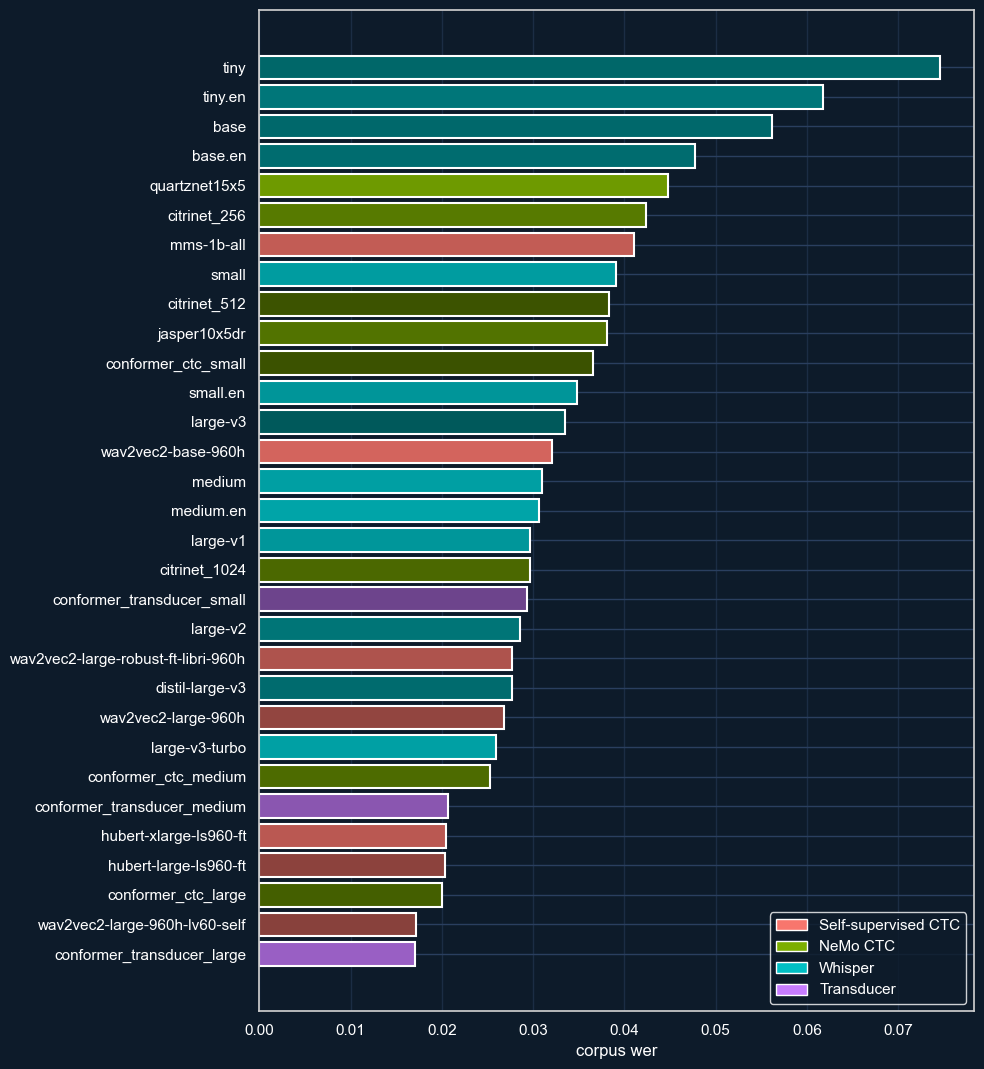

In [3]:
order_clean = make_order(summary_clean)
palette = ModelPalette(family_fn=model_family, family_base=family_colors, family_label=family_labels, shade_factor=0.55)
fig_corpus, ax_corpus, corpus_data = plot_corpus_wer_barh(summary_clean, order_clean, palette, return_data=True)

summary_clean

On LibriSpeech **dev-clean**, most utterances are short and easy, so after normalization many clips become exact matches. This is why the *median utterance WER is 0.0* for almost all models. In this setting, separation comes from the **hard tail**, so **corpus WER** and **p90 utterance WER** are more informative than the median.

The top results are extremely tight. **NeMo Conformer Transducer large** leads at **0.01707 corpus WER**, with *wav2vec2-large-960h-lv60-self* nearly identical at **0.01716**. The main takeaway is a shared *top tier* where small decoding or dataset details can shift ordering without changing the overall story.

A broader “high accuracy, stable” cluster sits around the **low 0.02** range (notably **Conformer CTC large** and **HuBERT large/xlarge**, with **Conformer Transducer medium** nearby). On dev-clean, these models mostly fail via **local substitutions**, not structural breakdowns.

**Whisper** models are strong but not leading here, and the tradeoff shows up clearly in **latency** due to autoregressive decoding. Their error profile is also different: they are more sensitive to decoding and segmentation, and can show occasional *insertion-heavy* failures. In this table, **Whisper large-v3** stands out for elevated insertions, which inflates its corpus WER.

**MMS (mms-1b-all)** behaves like a CTC baseline in runtime style, but is noticeably weaker on dev-clean (**0.041 corpus WER**), driven mainly by higher substitutions. This fits the expectation that MMS targets broad multilingual coverage rather than being narrowly optimized for LibriSpeech.


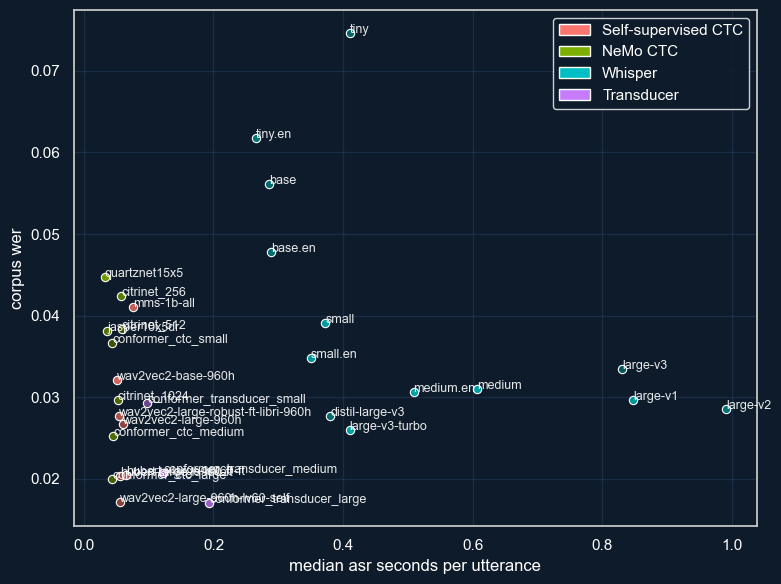

In [4]:
fig_sc, ax_sc, sc_data = plot_latency_vs_wer(summary_clean, order_clean, palette, return_data=True)

Most Whisper models are either really slow, or have higher WER, we are going to filter them out

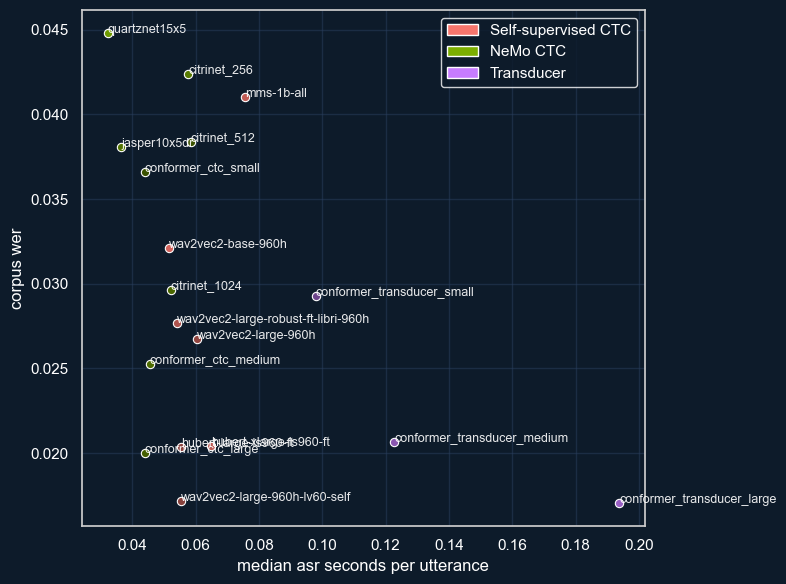

In [5]:
fig_sc, ax_sc, sc_data = plot_latency_vs_wer(summary_clean, order_clean, palette,families=["transducer","nemo_ctc", "ssl_ctc"]  ,return_data=True)

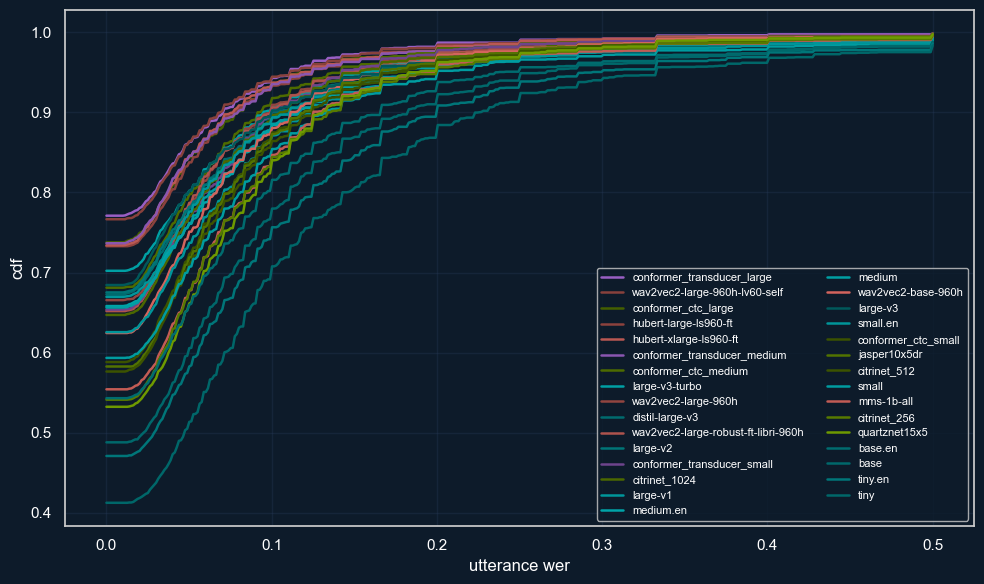

In [6]:
fig_cdf, ax_cdf, cdf_data = plot_wer_cdf(df_clean, order_clean, palette, return_data=True)

This is an empirical CDF of **utterance-level WER**. Higher curves are better: for any WER threshold on the x-axis, they cover a larger fraction of utterances.

- The y-intercept at **WER = 0** shows the **perfect-transcription rate**. The best models have a much higher mass at zero than the weaker ones.
- Most separation happens in the **low-WER region (~0 to 0.1)**, meaning models mainly differ in how often they make *small* mistakes, not in catastrophic failures.
- The top cluster is **Conformer Transducer large** and **wav2vec2-large-960h-lv60-self**, with **Conformer CTC large** and **HuBERT large/xlarge** close behind.
- **Whisper** models sit below the CTC and Transducer baselines, indicating fewer perfect utterances and a heavier tail of non-zero WER.
- Past roughly **0.2 WER**, curves converge near **1.0**, so remaining differences are concentrated in a small set of hard utterances.


In [7]:
win_counts = oracle_win_counts(df_clean, order_clean, tie_mode="fractional")
win_counts

,model,n_wins,win_share
0,conformer_transducer_large,143.694941,0.053161
1,wav2vec2-large-960h-lv60-self,133.254441,0.049299
2,hubert-large-ls960-ft,120.359166,0.044528
3,hubert-xlarge-ls960-ft,113.912248,0.042143
4,conformer_transducer_medium,112.863322,0.041755
5,conformer_ctc_large,109.361682,0.040459
6,large-v3,105.150019,0.038901
7,large-v3-turbo,101.189970,0.037436
8,large-v2,98.201368,0.036331
9,conformer_ctc_medium,92.821142,0.034340


A fractional oracle selection analysis (splitting credit across all models that tie for lowest utterance WER) shows that wins are widely dispersed on dev-clean. This is expected because many utterances become exact matches after normalization, producing large tie sets at WER = 0. Under fractional credit, conformer_transducer_large has the highest win share at ~5.3% (143.7 fractional wins out of 2703), followed closely by wav2vec2-large-960h-lv60-self at ~4.9%. Many other models contribute comparable win shares in the ~2% to ~4% range, indicating that on dev-clean the “oracle” notion mostly reflects how often a model is included in the tie-for-best group rather than clear per-utterance dominance.

## 2.2. On dev-other

In [8]:
df_other = load_eval_df("results", "dev-other")
summary_other = summarize_eval_df(df_other)
order_other = make_order(summary_other)
palette = make_default_palette()
df_other.head()

,model,dataset,id,wer,substitutions,deletions,insertions,ref_words,hyp_words,asr_seconds,err_words
0,base,dev-other,116-288045-0000,0.181818,4,1,1,33,33,0.9720,6
1,base,dev-other,116-288045-0001,0.000000,0,0,0,22,22,0.4900,0
2,base,dev-other,116-288045-0002,0.037037,1,0,0,27,27,0.3789,1
3,base,dev-other,116-288045-0003,0.090909,1,0,0,11,11,0.2690,1
4,base,dev-other,116-288045-0004,0.000000,0,0,0,13,13,0.3011,0


,model,n_utts,total_ref_words,total_S,total_D,total_I,total_err,mean_item_wer,median_item_wer,p90_item_wer,total_asr_seconds,median_asr_seconds,p90_asr_seconds,corpus_wer,sec_per_ref_word,S_per_word,D_per_word,I_per_word
0,hubert-xlarge-ls960-ft,2864,51585,1513,111,122,1746,0.036991,0.000000,0.117647,195.4252,0.06620,0.07887,0.033847,0.003788,0.029330,0.002152,0.002365
1,conformer_transducer_large,2864,51585,1476,187,148,1811,0.040295,0.000000,0.125000,685.7836,0.20960,0.36750,0.035107,0.013294,0.028613,0.003625,0.002869
2,wav2vec2-large-960h-lv60-self,2864,51585,1529,147,150,1826,0.042115,0.000000,0.125000,183.6711,0.06220,0.07487,0.035398,0.003561,0.029640,0.002850,0.002908
3,hubert-large-ls960-ft,2864,51585,1811,155,165,2131,0.046281,0.000000,0.142857,179.3193,0.06080,0.07470,0.041310,0.003476,0.035107,0.003005,0.003199
4,large-v3-turbo,2864,51585,1755,213,182,2150,0.049374,0.000000,0.142857,1103.7896,0.37110,0.45440,0.041679,0.021397,0.034022,0.004129,0.003528
5,conformer_ctc_large,2864,51585,1880,184,188,2252,0.048842,0.000000,0.142857,145.0840,0.04970,0.05530,0.043656,0.002813,0.036445,0.003567,0.003644
6,large-v3,2864,51585,1607,198,570,2375,0.058206,0.000000,0.142857,2429.9064,0.72670,1.16168,0.046041,0.047105,0.031152,0.003838,0.011050
7,conformer_transducer_medium,2864,51585,1939,235,213,2387,0.051557,0.000000,0.157895,372.6056,0.11505,0.19604,0.046273,0.007223,0.037588,0.004556,0.004129
8,wav2vec2-large-robust-ft-libri-960h,2864,51585,2346,178,192,2716,0.057737,0.000000,0.166667,190.4119,0.06500,0.07807,0.052651,0.003691,0.045478,0.003451,0.003722
9,distil-large-v3,2864,51585,2248,268,253,2769,0.061739,0.000000,0.181818,1455.1484,0.50160,0.57390,0.053678,0.028209,0.043579,0.005195,0.004905


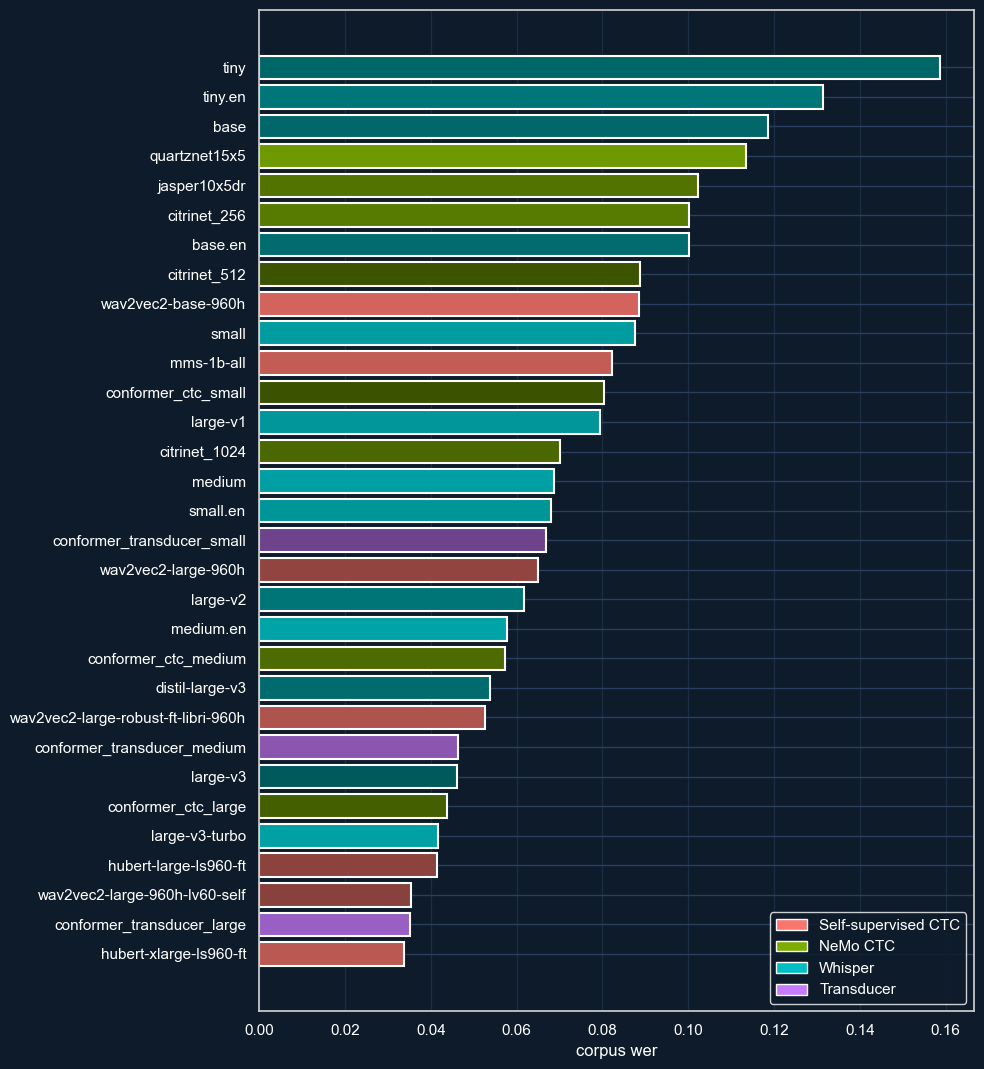

In [9]:
order_other = make_order(summary_other)
fig_corpus, ax_corpus, corpus_data = plot_corpus_wer_barh(summary_other, order_other, palette, return_data=True)

summary_other

Moving from **dev-clean** to **dev-other**, every model shows a clear degradation in accuracy. This is expected: dev-other contains harder acoustic conditions and generally produces more substitutions, deletions, and insertions across the board. The ranking also becomes more informative because fewer utterances are perfectly recognized, so differences are less dominated by trivial exact matches.

The most striking shift is that **HuBERT xlarge fine-tuned on LibriSpeech (hubert-xlarge-ls960-ft)** ends up **leading on corpus WER**, while remaining in the fast, CTC-style latency regime. It is also one of the models whose performance increases the least relative to dev-clean, suggesting better robustness rather than simply a change in ordering due to small margins.

A plausible reason HuBERT holds up better under dev-other conditions is its **self-supervised pretraining objective**. HuBERT is trained to learn stable speech representations from large amounts of unlabeled audio by predicting masked or clustered targets. This encourages the encoder to focus on phonetic and linguistic structure that stays consistent across variations, and to be less sensitive to surface-level corruption such as channel changes, background noise, or mild mismatches in segmentation. In contrast, models whose decoding relies more heavily on autoregressive generation or on fragile alignment behavior can be more exposed to noisy acoustics through cascaded decoding errors, leading to heavier tails and more insertion-heavy failures.

Overall, dev-other reinforces the main story of the benchmark: the best models remain close on clean audio, but robustness separates them more on harder conditions, and HuBERT appears particularly strong in that regime.


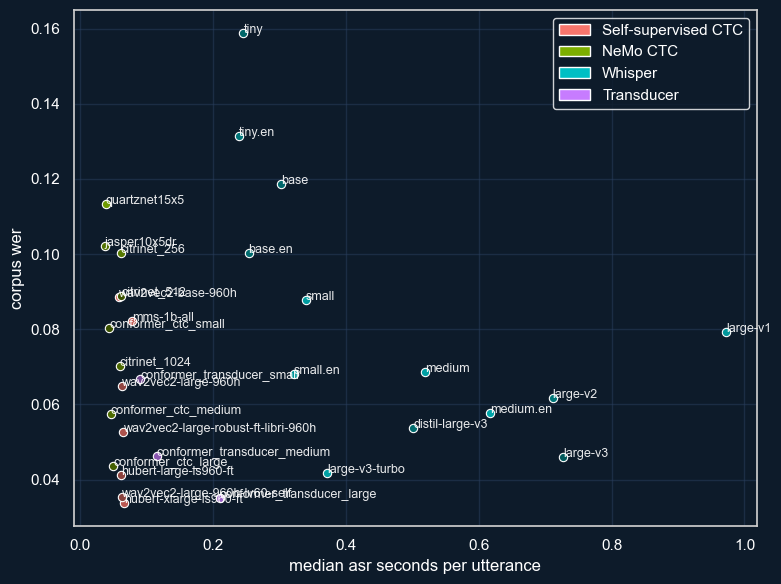

In [10]:
fig_sc, ax_sc, sc_data = plot_latency_vs_wer(summary_other, order_other, palette, return_data=True)

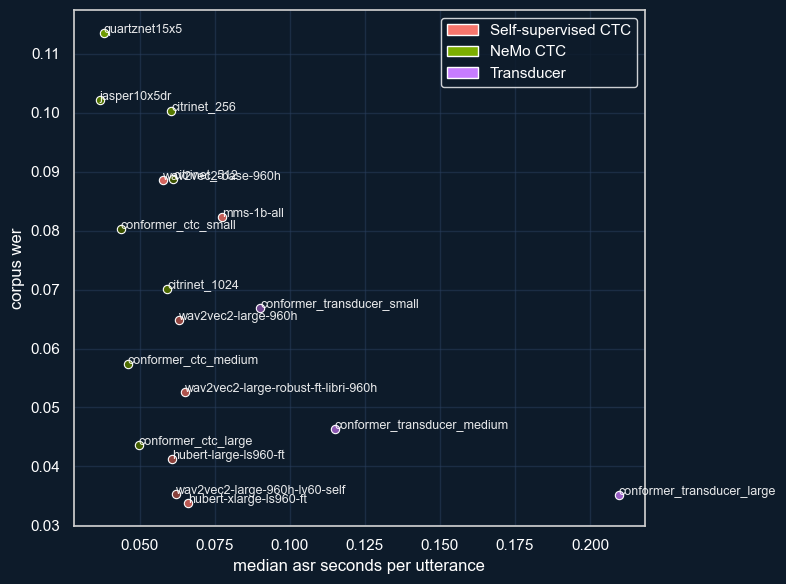

In [11]:
fig_sc, ax_sc, sc_data = plot_latency_vs_wer(summary_other, order_other, palette,families=["transducer","nemo_ctc", "ssl_ctc"]  ,return_data=True)

### Conclusion and model choice

The benchmark indicates that performance on **dev-other** is the most relevant proxy for real user uploads, since it better reflects acoustic variability and harder conditions than dev-clean. On this split, **hubert-xlarge-ls960-ft** achieves the best corpus WER among the tested models while remaining in a fast CTC inference regime, which supports predictable processing time.

However, HuBERT (and the other LibriSpeech-fine-tuned CTC baselines) should be interpreted as **English-focused, in-domain** choices. If the product requirement includes **unknown or mixed languages** in arbitrary user uploads, the safer single-model default is **Whisper large-v3-turbo**, trading some LibriSpeech WER for broader language coverage and more reliable out-of-domain behavior.

A secondary takeaway is that **conformer_transducer_large** remains a top-tier accuracy baseline, especially on dev-clean, but its inference cost is substantially higher in the current measurements and its advantage does not hold on dev-other. Overall, the selection depends on scope: **HuBERT xlarge** is the strongest choice for an English-only system, while **large-v3-turbo** is the most defensible single-model choice for multilingual, open-world uploads.
